# Other Samplers

Trey V. Wenger (c) August 2024

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.5.0


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Text(0, 0.5, 'Brightness Temperature (K)')

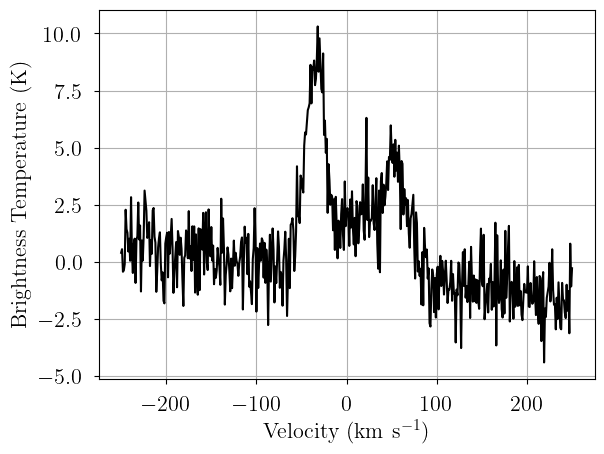

In [3]:
from bayes_spec.models import GaussNoiseModel

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's use a lot of chains and the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 8,
    cores = 8,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


In [7]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 1 order: [2 1 0]
Chain 2 order: [2 1 0]
Chain 3 order: [2 0 1]
Chain 4 order: [1 2 0]
Chain 5 order: [1 0 2]
Chain 6 order: [2 0 1]
Chain 7 order: [1 2 0]
Adopting (first) most common order: [1 2 0]


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

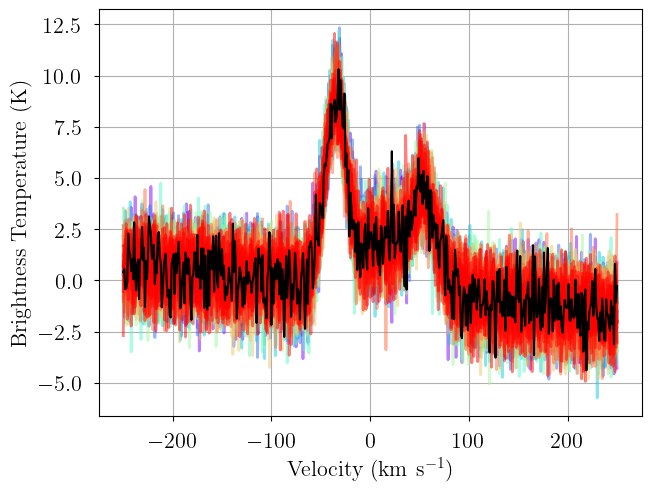

In [8]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

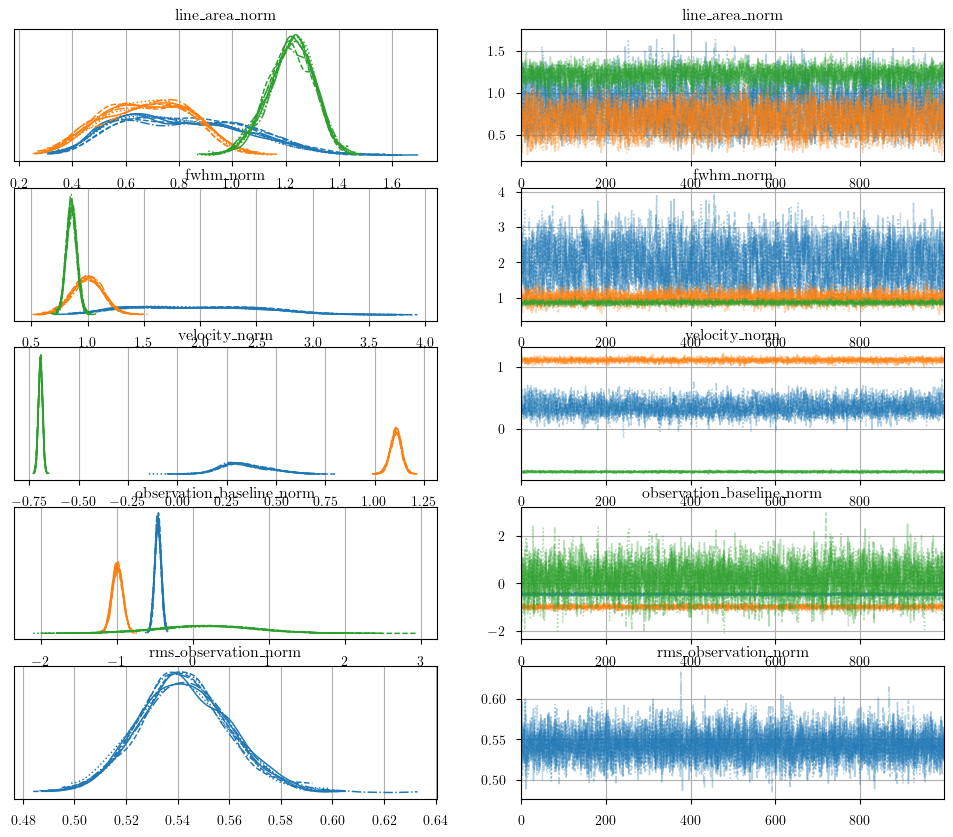

In [9]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    2.605   0.273    2.099    3.123      0.003   
amplitude[1]                    4.229   0.639    3.062    5.301      0.013   
amplitude[2]                    8.887   0.402    8.107    9.625      0.006   
fwhm[0]                        59.128  16.737   31.025   87.610      0.387   
fwhm[1]                        29.977   4.072   22.102   37.435      0.082   
fwhm[2]                        25.744   1.383   23.285   28.462      0.023   
fwhm_norm[0]                    1.971   0.558    1.034    2.920      0.013   
fwhm_norm[1]                    0.999   0.136    0.737    1.248      0.003   
fwhm_norm[2]                    0.858   0.046    0.776    0.949      0.001   
line_area[0]                  163.072  46.670   85.467  245.944      1.093   
line_area[1]                  136.187  32.420   77.060  192.283      0.741   
line_area[2]                  243.564  17.247  210.481  274.714      0.338   
line_area_norm[0]               0.815   0.233    0.427    1.230      0.005   
line_area_norm[1]               0.681   0.162    0.385    0.961      0.004   
line_area_norm[2]               1.218   0.086    1.052    1.374      0.002   
observation_baseline_norm[0]   -0.460   0.042   -0.546   -0.385      0.001   
observation_baseline_norm[1]   -0.993   0.070   -1.120   -0.857      0.001   
observation_baseline_norm[2]    0.178   0.641   -1.046    1.372      0.010   
rms_observation                 1.085   0.035    1.018    1.150      0.000   
rms_observation_norm            0.542   0.017    0.509    0.575      0.000   
velocity[0]                    17.140   5.910    7.264   29.040      0.114   
velocity[1]                    55.359   1.406   52.594   57.914      0.021   
velocity[2]                   -34.681   0.523  -35.633  -33.673      0.007   
velocity_norm[0]                0.343   0.118    0.145    0.581      0.002   
velocity_norm[1]                1.107   0.028    1.052    1.158      0.000   
velocity_norm[2]               -0.694   0.010   -0.713   -0.673      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.002    6162.0    6068.0    1.0  
amplitude[1]                    0.009    2385.0    5159.0    1.0  
amplitude[2]                    0.004    4446.0    5894.0    1.0  
fwhm[0]                         0.274    1907.0    4240.0    1.0  
fwhm[1]                         0.058    2493.0    3620.0    1.0  
fwhm[2]                         0.016    3723.0    4324.0    1.0  
fwhm_norm[0]                    0.009    1907.0    4240.0    1.0  
fwhm_norm[1]                    0.002    2493.0    3620.0    1.0  
fwhm_norm[2]                    0.001    3723.0    4324.0    1.0  
line_area[0]                    0.773    1848.0    4291.0    1.0  
line_area[1]                    0.524    1940.0    3431.0    1.0  
line_area[2]                    0.239    2650.0    4024.0    1.0  
line_area_norm[0]               0.004    1848.0    4291.0    1.0  
line_area_norm[1]               0.003    1940.0    3431.0    1.0  
line_area_norm[2]               0.001    2650.0    4024.0    1.0  
observation_baseline_norm[0]    0.000    4439.0    4632.0    1.0  
observation_baseline_norm[1]    0.001    9142.0    5773.0    1.0  
observation_baseline_norm[2]    0.007    4500.0    5589.0    1.0  
rms_observation                 0.000    8257.0    5836.0    1.0  
rms_observation_norm            0.000    8257.0    5836.0    1.0  
velocity[0]                     0.082    2806.0    3798.0    1.0  
velocity[1]                     0.015    4358.0    4891.0    1.0  
velocity[2]                     0.005    5148.0    6093.0    1.0  
velocity_norm[0]                0.002    2806.0    3798.0    1.0  
velocity_norm[1]                0.000    4358.0    4891.0    1.0  
velocity_norm[2]                0.000    5148.0    6093.0    1.0

Here's what I wanted to say:

```
The solution looks *ok*, but inspecting the trace plots and the `r_hat` statistic reveals that the model hasn't converged very well! This is a complicated, multi-modal posterior, and without the help of variational inference getting NUTS to a good starting point, we just have a hard time sampling from this posterior.
```

In reality, however, NUTS has no problem with this model, even with the default initialization! That might not always be the case, so let's play with the other samplers anyway.

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [11]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

In [12]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

Only 7 chains appear converged.


In [13]:
model.solve(p_threshold=0.9)

GMM found 2 unique solutions
Solution 0: chains [0, 2, 3, 4, 6]
Solution 1: chains [5, 7]
Label order mismatch in solution 0
Chain 0 order: [1 2 0]
Chain 2 order: [0 1 2]
Chain 3 order: [1 0 2]
Chain 4 order: [1 0 2]
Chain 6 order: [2 0 1]
Adopting (first) most common order: [1 0 2]
Label order mismatch in solution 1
Chain 5 order: [0 2 1]
Chain 7 order: [0 1 2]
Adopting (first) most common order: [0 1 2]


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

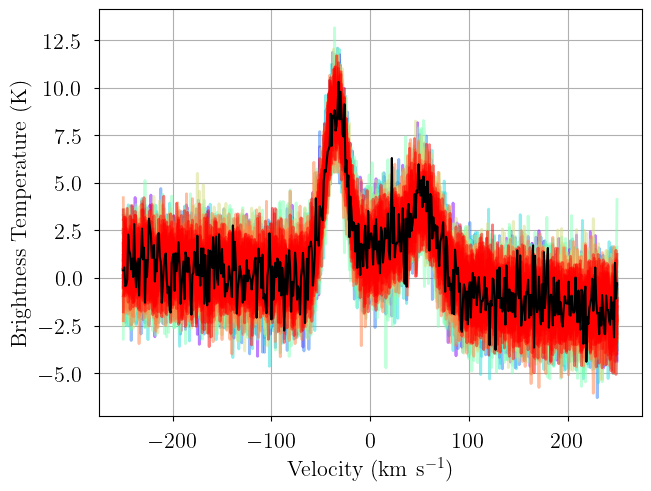

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

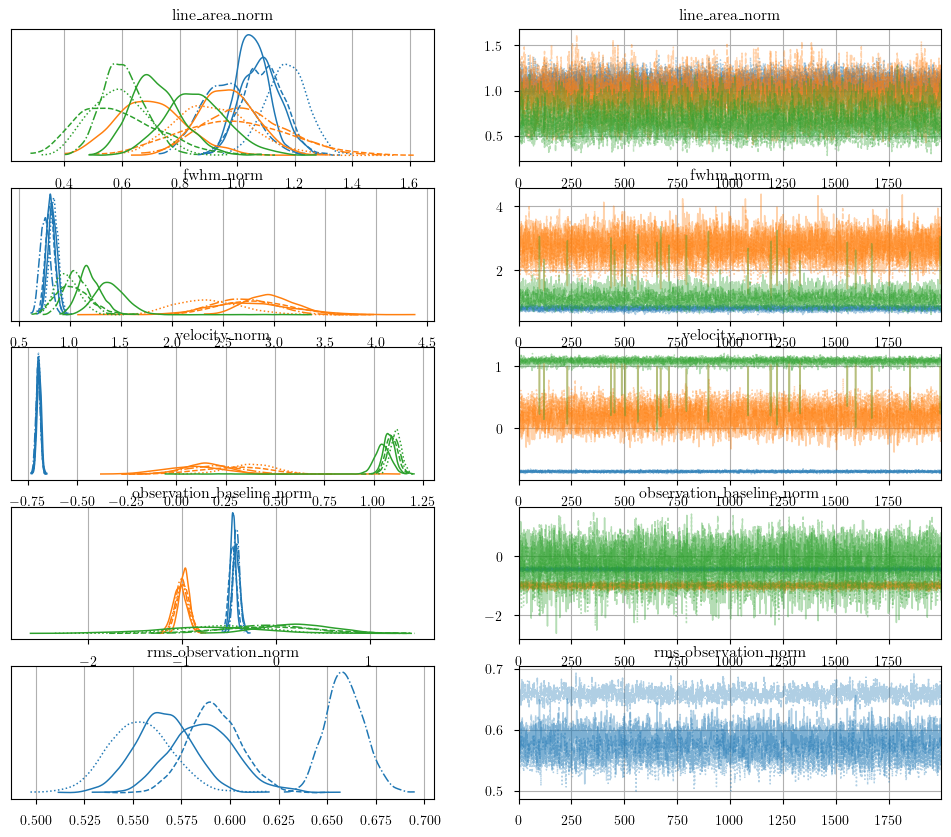

In [15]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussNoiseModel` has an option to do just this: `add_priors(ordered=True)`. Note that this changes the definition of the prior distribution on `velocity`. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [16]:
model = GaussNoiseModel(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
    ordered = True, # enforce ordered velocities
)
model.add_likelihood()

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

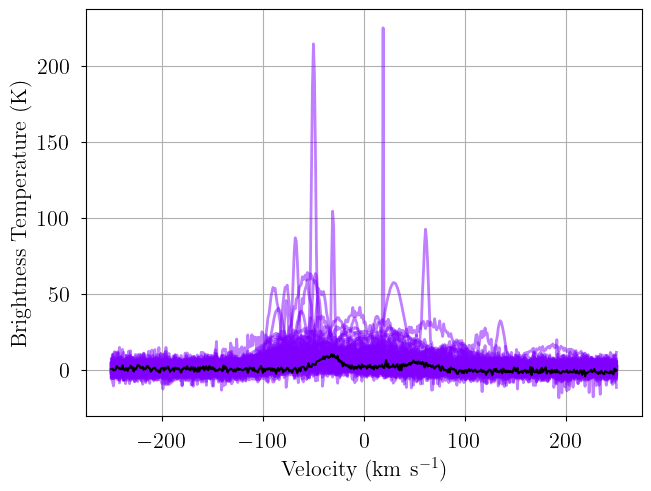

In [17]:
# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

In [18]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

In [19]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

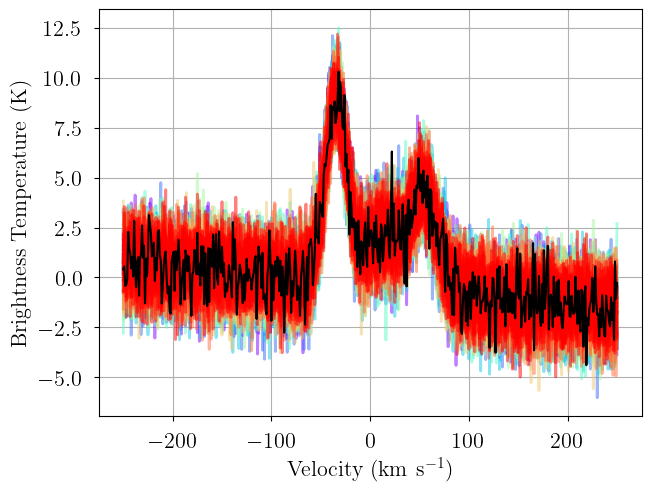

In [20]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

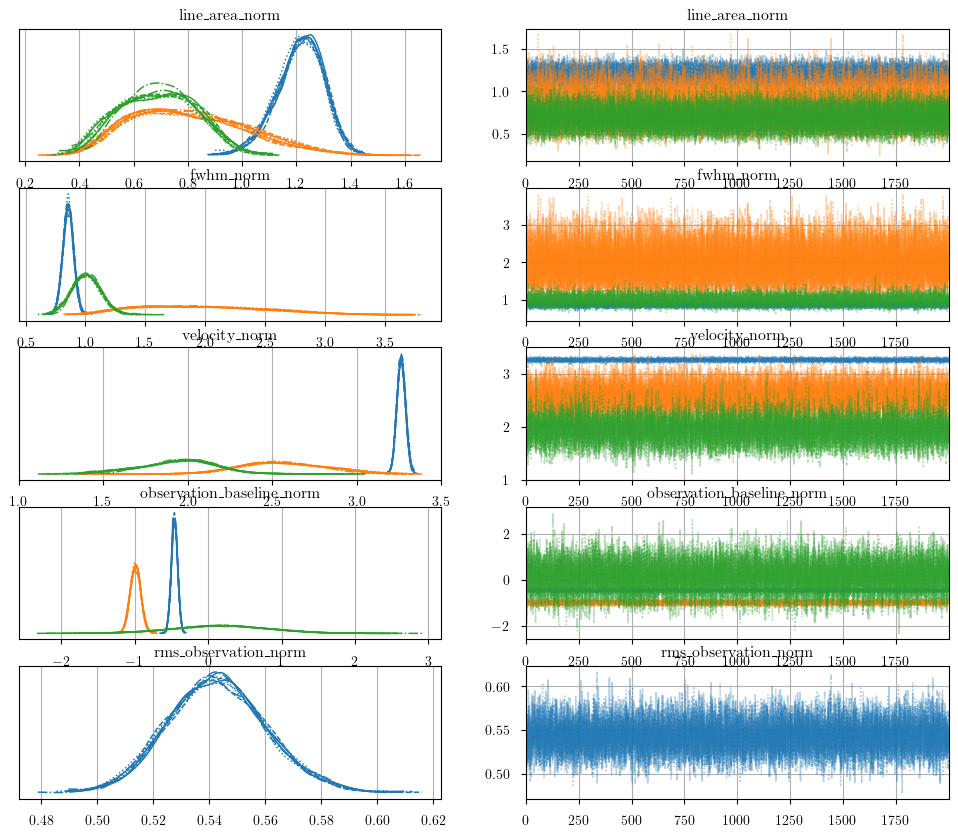

In [21]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [22]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.874   0.403    8.094    9.615      0.003   
amplitude[1]                    2.578   0.261    2.098    3.078      0.002   
amplitude[2]                    4.267   0.570    3.240    5.291      0.005   
fwhm[0]                        25.689   1.363   23.194   28.345      0.011   
fwhm[1]                        59.262  15.793   33.394   88.266      0.135   
fwhm[2]                        30.234   3.595   23.149   36.660      0.031   
fwhm_norm[0]                    0.856   0.045    0.773    0.945      0.000   
fwhm_norm[1]                    1.975   0.526    1.113    2.942      0.004   
fwhm_norm[2]                    1.008   0.120    0.772    1.222      0.001   
line_area[0]                  242.687  17.294  209.273  274.069      0.143   
line_area[1]                  161.520  42.245   91.253  240.666      0.365   
line_area[2]                  138.016  27.980   87.688  187.475      0.253   
line_area_norm[0]               1.213   0.086    1.046    1.370      0.001   
line_area_norm[1]               0.808   0.211    0.456    1.203      0.002   
line_area_norm[2]               0.690   0.140    0.438    0.937      0.001   
observation_baseline_norm[0]   -0.459   0.042   -0.538   -0.377      0.000   
observation_baseline_norm[1]   -0.991   0.070   -1.120   -0.857      0.001   
observation_baseline_norm[2]    0.175   0.644   -1.007    1.420      0.005   
rms_observation                 1.086   0.035    1.023    1.154      0.000   
rms_observation_norm            0.543   0.017    0.511    0.577      0.000   
velocity[0]                   -34.713   0.508  -35.640  -33.750      0.004   
velocity[1]                    16.551   5.129    7.872   26.536      0.045   
velocity[2]                    55.483   1.373   52.871   58.073      0.011   
velocity_norm[0]                3.264   0.025    3.218    3.313      0.000   
velocity_norm[1]                2.563   0.256    2.125    3.056      0.002   
velocity_norm[2]                1.947   0.230    1.479    2.335      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.002   14343.0   14932.0    1.0  
amplitude[1]                    0.002   14364.0   14544.0    1.0  
amplitude[2]                    0.003   13164.0   12130.0    1.0  
fwhm[0]                         0.008   15352.0   14228.0    1.0  
fwhm[1]                         0.095   13328.0   11929.0    1.0  
fwhm[2]                         0.022   12981.0   12210.0    1.0  
fwhm_norm[0]                    0.000   15352.0   14228.0    1.0  
fwhm_norm[1]                    0.003   13328.0   11929.0    1.0  
fwhm_norm[2]                    0.001   12981.0   12210.0    1.0  
line_area[0]                    0.101   14659.0   14762.0    1.0  
line_area[1]                    0.259   13071.0   11348.0    1.0  
line_area[2]                    0.179   11145.0   10121.0    1.0  
line_area_norm[0]               0.001   14659.0   14762.0    1.0  
line_area_norm[1]               0.001   13071.0   11348.0    1.0  
line_area_norm[2]               0.001   11145.0   10121.0    1.0  
observation_baseline_norm[0]    0.000   15650.0   15473.0    1.0  
observation_baseline_norm[1]    0.000   15443.0   15031.0    1.0  
observation_baseline_norm[2]    0.004   15804.0   15737.0    1.0  
rms_observation                 0.000   15254.0   15351.0    1.0  
rms_observation_norm            0.000   15254.0   15351.0    1.0  
velocity[0]                     0.003   15609.0   15310.0    1.0  
velocity[1]                     0.035   12243.0    9285.0    1.0  
velocity[2]                     0.008   14869.0   13155.0    1.0  
velocity_norm[0]                0.000   15609.0   15310.0    1.0  
velocity_norm[1]                0.002   11251.0    9275.0    1.0  
velocity_norm[2]                0.001   12183.0    8672.0    1.0

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference). Thus we only consider the `GaussNoiseModel` model with `ordered=True`.

In [23]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

Only 4 chains appear converged.


After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [24]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

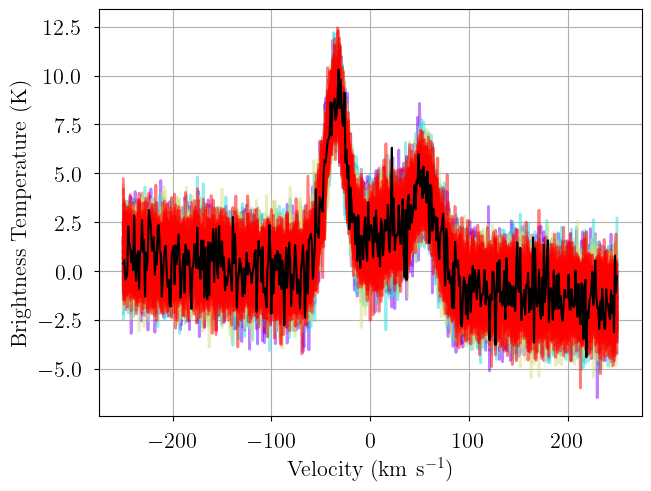

In [25]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

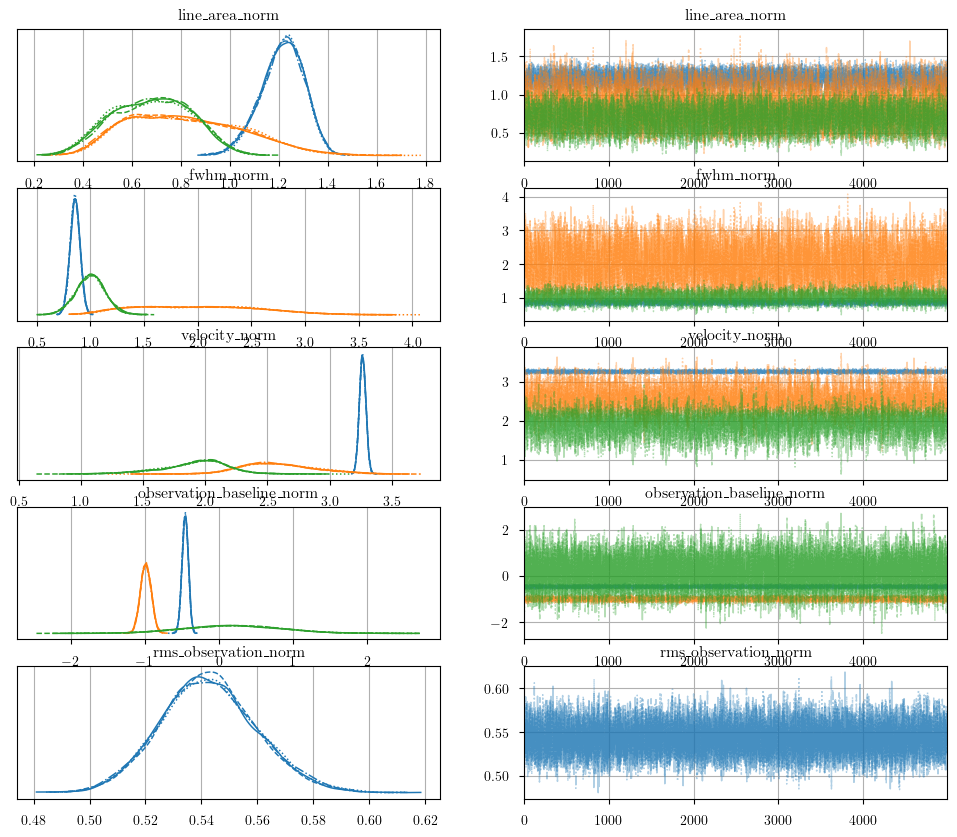

In [26]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [27]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     242.881  17.458  208.253  273.163      0.249    0.176   
line_area[1]     163.930  46.344   85.518  246.340      0.815    0.576   
line_area[2]     136.056  31.819   78.402  192.268      0.575    0.406   
fwhm[0]           25.713   1.380   23.052   28.261      0.016    0.011   
fwhm[1]           59.668  16.777   30.534   88.396      0.289    0.204   
fwhm[2]           30.037   4.087   22.415   37.877      0.061    0.043   
velocity[0]      -34.688   0.516  -35.620  -33.677      0.005    0.003   
velocity[1]       17.035   5.883    6.996   28.925      0.100    0.073   
velocity[2]       55.353   1.420   52.697   58.013      0.015    0.010   
amplitude[0]       8.872   0.402    8.089    9.606      0.005    0.003   
amplitude[1]       2.596   0.275    2.095    3.123      0.002    0.002   
amplitude[2]       4.219   0.625    3.068    5.278      0.010    0.007   
rms_observation    1.085   0.034    1.022    1.151      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       5075.0    6287.0    1.0  
line_area[1]       3302.0    8598.0    1.0  
line_area[2]       3098.0    5022.0    1.0  
fwhm[0]            7545.0    9357.0    1.0  
fwhm[1]            3470.0    8979.0    1.0  
fwhm[2]            4461.0    6287.0    1.0  
velocity[0]       11213.0   14696.0    1.0  
velocity[1]        3601.0    4716.0    1.0  
velocity[2]        9625.0   12084.0    1.0  
amplitude[0]       8186.0    9446.0    1.0  
amplitude[1]      12708.0   15017.0    1.0  
amplitude[2]       3719.0    7817.0    1.0  
rms_observation   24953.0   14344.0    1.0

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [28]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [29]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [30]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

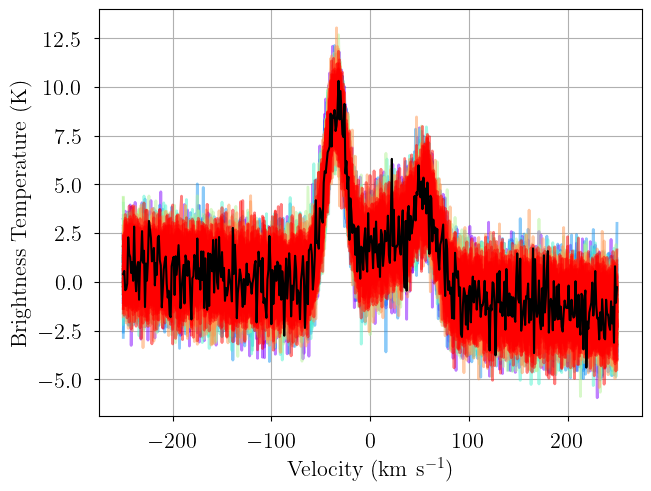

In [31]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

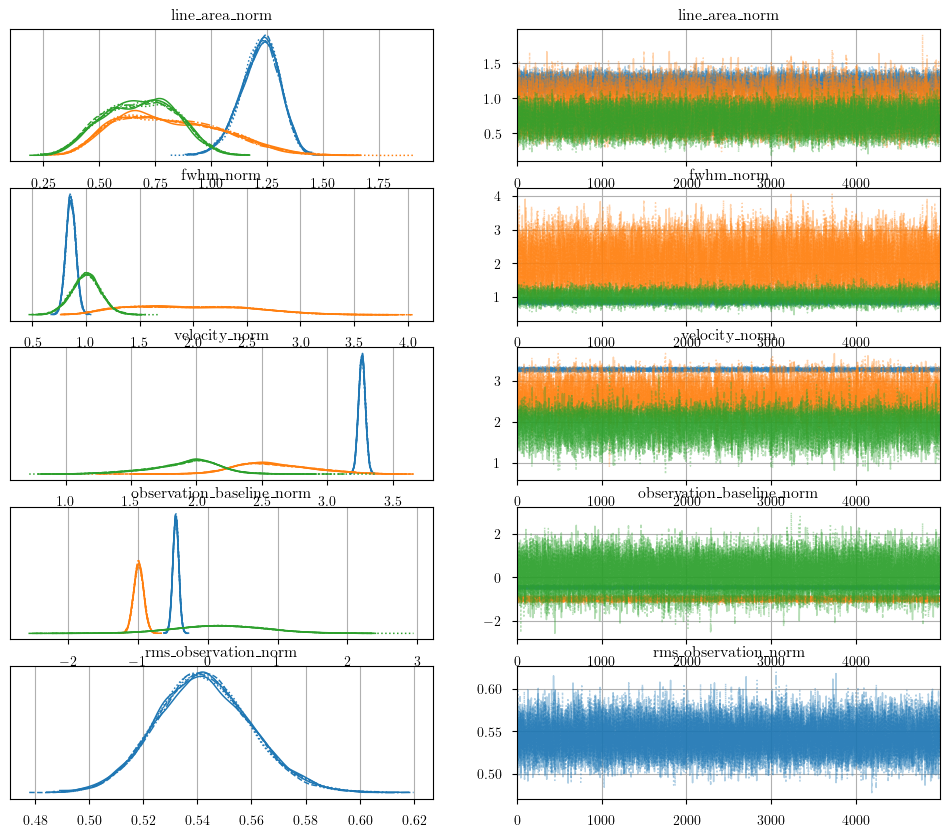

In [32]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [33]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     243.410  17.274  210.891  275.210      0.188    0.133   
line_area[1]     163.069  46.476   84.501  246.244      0.589    0.417   
line_area[2]     136.264  32.096   78.393  193.194      0.401    0.284   
fwhm[0]           25.753   1.377   23.179   28.358      0.013    0.009   
fwhm[1]           59.252  16.663   30.964   88.058      0.209    0.148   
fwhm[2]           30.010   4.075   22.172   37.592      0.042    0.030   
velocity[0]      -34.688   0.518  -35.657  -33.713      0.004    0.003   
velocity[1]       17.124   5.860    7.251   29.011      0.066    0.049   
velocity[2]       55.369   1.429   52.639   58.033      0.011    0.008   
amplitude[0]       8.878   0.398    8.118    9.611      0.003    0.002   
amplitude[1]       2.599   0.274    2.090    3.119      0.002    0.001   
amplitude[2]       4.228   0.629    3.079    5.297      0.007    0.005   
rms_observation    1.085   0.035    1.019    1.150      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       8649.0   11755.0    1.0  
line_area[1]       6369.0   15219.0    1.0  
line_area[2]       6528.0   11135.0    1.0  
fwhm[0]           11627.0   15022.0    1.0  
fwhm[1]            6547.0   16098.0    1.0  
fwhm[2]            9353.0   12783.0    1.0  
velocity[0]       15890.0   19896.0    1.0  
velocity[1]        8121.0   10062.0    1.0  
velocity[2]       18041.0   21279.0    1.0  
amplitude[0]      15924.0   17879.0    1.0  
amplitude[1]      22331.0   22720.0    1.0  
amplitude[2]       7554.0   15989.0    1.0  
rms_observation   27253.0   20941.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [34]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


In [35]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

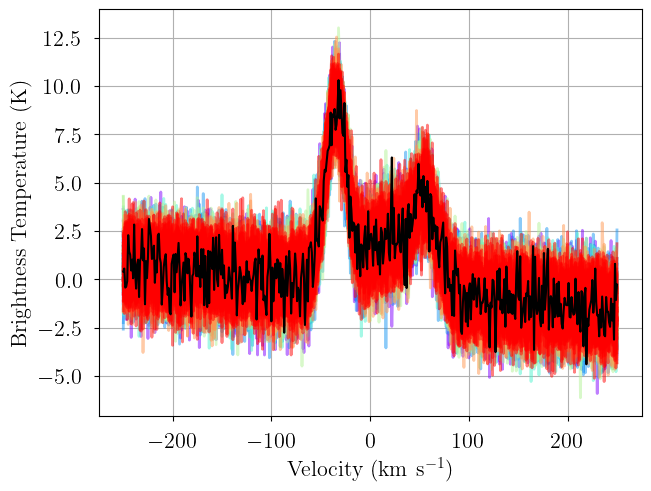

In [36]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'line_area_norm'}>,
        <Axes: title={'center': 'line_area_norm'}>],
       [<Axes: title={'center': 'fwhm_norm'}>,
        <Axes: title={'center': 'fwhm_norm'}>],
       [<Axes: title={'center': 'velocity_norm'}>,
        <Axes: title={'center': 'velocity_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

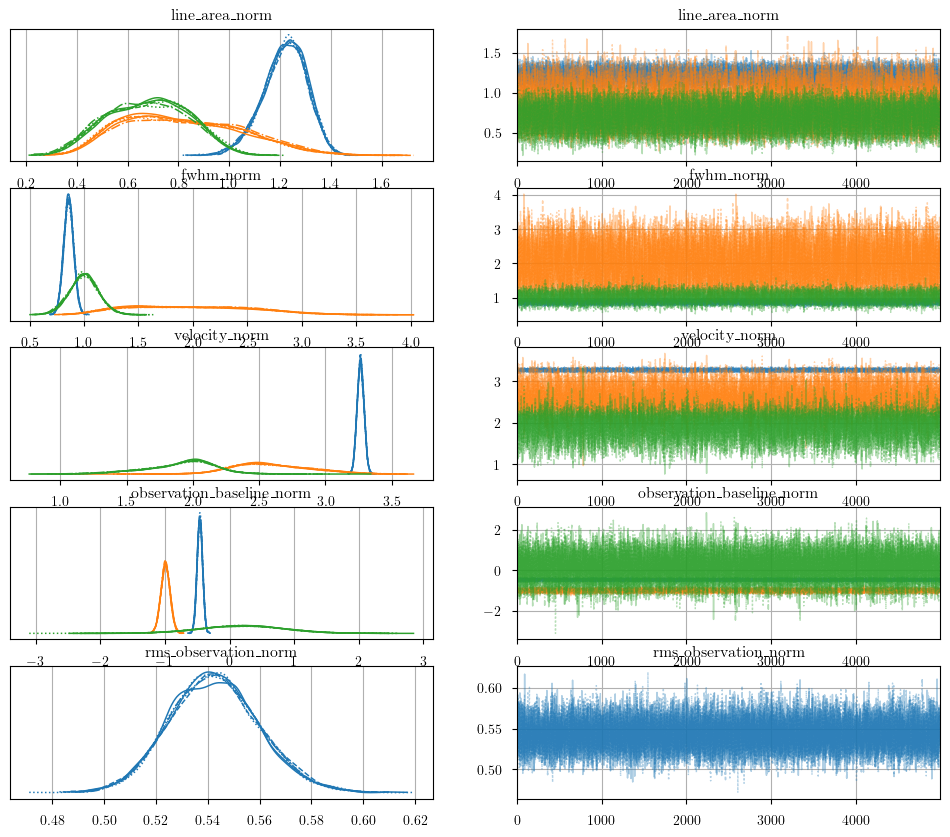

In [37]:
plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

In [38]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     243.605  17.195  210.591  274.661      0.193    0.136   
line_area[1]     163.336  46.234   84.492  245.406      0.595    0.421   
line_area[2]     136.128  31.837   79.364  193.167      0.406    0.287   
fwhm[0]           25.756   1.363   23.083   28.229      0.013    0.009   
fwhm[1]           59.294  16.654   30.881   88.000      0.216    0.152   
fwhm[2]           29.986   4.006   22.553   37.743      0.042    0.030   
velocity[0]      -34.687   0.518  -35.685  -33.755      0.004    0.003   
velocity[1]       17.150   5.803    7.469   28.817      0.065    0.048   
velocity[2]       55.394   1.419   52.589   57.952      0.011    0.008   
amplitude[0]       8.884   0.400    8.136    9.631      0.003    0.002   
amplitude[1]       2.603   0.274    2.098    3.135      0.002    0.001   
amplitude[2]       4.228   0.632    3.091    5.331      0.008    0.005   
rms_observation    1.085   0.034    1.021    1.150      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       8085.0   10975.0    1.0  
line_area[1]       6185.0   15265.0    1.0  
line_area[2]       6255.0   11397.0    1.0  
fwhm[0]           11266.0   15117.0    1.0  
fwhm[1]            6160.0   16807.0    1.0  
fwhm[2]            9195.0   12421.0    1.0  
velocity[0]       15724.0   19973.0    1.0  
velocity[1]        8275.0   11137.0    1.0  
velocity[2]       17471.0   20711.0    1.0  
amplitude[0]      14593.0   16967.0    1.0  
amplitude[1]      22925.0   23285.0    1.0  
amplitude[2]       7095.0   16023.0    1.0  
rms_observation   26205.0   20727.0    1.0